<center><h1 style="font-size:40px;">Exercise II: Classification</h1></center>

---

For this exercise you are given two classification problems with a fixed training-, validation- and test dataset. A spiral dataset and a japanese vowels dataset.

The **task** is to do model selection, coming up with your optimal MLP architecture together with the hyperparameters. For this part no code for the configuration or training are given. Please implement this based on the previous parts. A small evaluation section is provided to observe the confusion matrix for the prediction vs target.

# Data
## Japanese vowels dataset
This data set is taken from the UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels]. In short, nine male speakers uttered two Japanese vowels /ae/ successively. For each utterance, a discrete times series was produced where each time point consists of 12 (LPC cepstrum) coefficients. The length of each time series was between 7-29. 
Here we treat each point of the time series as a feature (12 inputs). In total we have 9961
data points which then has been divided into 4274 for training, 2275 for validation and 3412 for test. The original data files are provided as *ae.train* and *ae.test*. The task is now based on a single sample value of one of the speakers, determine which speaker it was. This is, in summary, a 9-class classification problem with 12 input values for each case.

## Spiral data
This is the "famous" spiral dataset that consists of two 2-D spirals, one for each class. The perfect classification boundary is also a spiral. The cell "PlotData" will plot this dataset.

# Code

The following code allows us to edit imported files without restarting the kernel for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

# Hacky solution to access the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from config import LabConfig
from dataset import MLPData
from utils.model import Model
from utils.progressbar import LitProgressBar
from utils.model import Model
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics
from utils import (
    plot,
    progressbar
) 

In [3]:
cfg = LabConfig()

## Task 1
**TODO:** Present an MLP for the Japanese vowels dataset with associated hyperparameters that maximizes the validation performance and give the test performance you obtained. \
**TODO:** Motivate the choice of parameters and implementation. 

**Hint 2:** This problem is a 9-class classification problem, meaning that you should use a specific output activation function (*out_act_fun*) and a specific loss/error function (*cost_fun*).

In [161]:
# Load dataset - Vowels
from utils.utils import onehot2int
def numpy2Dataloader(x,y, batch_size=80, num_workers=0,**kwargs):
    return DataLoader(
        TensorDataset(
            torch.from_numpy(x).float(), 
            torch.from_numpy(np.argmax(y,axis=1)).long()
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        **kwargs
    )

x_train, y_train, x_val, y_val, x_test, y_test = MLPData.vowels(file_name_train=cfg.ae_train, file_name_test=cfg.ae_test)

train_loader = numpy2Dataloader(x_train,y_train)
val_loader =  numpy2Dataloader(x_val,y_val)
test_loader =  numpy2Dataloader(x_test,y_test)

num_classes = 9
print(f'|{"Type":10} | {"Input size":10} | {"Target size":10}|')
print(f'|{"-"*11}|{"-"*12}|{"-"*12}|')
print(f'|{"train":10} | {str(x_train.shape):10} | {str(y_train.shape):10} |')
print(f'|{"val":8}   | {str(x_val.shape):10} | {str(y_val.shape):10} |')
print(f'|{"test":9}  | {str(x_test.shape):10} | {str(y_test.shape):10} |')

|Type       | Input size | Target size|
|-----------|------------|------------|
|train      | (4274, 12) | (4274, 9)  |
|val        | (2275, 12) | (2275, 9)  |
|test       | (3412, 12) | (3412, 9)  |


### Model

In [191]:
class MLP(torch.nn.Module):
    def __init__(self, 
                inp_dim=None,         
                hidden_nodes=1, # number of nodes in hidden layer
                num_layers=1,
                num_out=None,
                **kwargs
            ):
        super(MLP, self).__init__()
        layers = []
        # Input
        layers.append(torch.nn.Linear(inp_dim, hidden_nodes))
        layers.append(torch.nn.ReLU())
        # Hidden
        for i in range(num_layers):
            layers.append(torch.nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(torch.nn.ReLU())
        # Output
        layers.append(torch.nn.Linear(hidden_nodes, num_out))
        #layers.append(torch.nn.Softmax())
        self.sequential = torch.nn.Sequential(*layers) # Unpacking all layers into a Sequential container
    
    def forward(self, x):
        return self.sequential(x)

### Config

In [247]:
config = {
    'max_epochs':100,
    'model_params':{
        'inp_dim':12,         
        'hidden_nodes':80,   # activation functions for the hidden layer,
        'hidden_layers':0,
        'num_out':9 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.004,
            'weight_decay':0.001
            
        }
    }
}

### Run Model

In [248]:
model = Model(MLP(**config["model_params"]),**config)

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=0,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[TQDMProgressBar(1)],
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,
        )
trainer.fit(
    model, 
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 0:  65%|██████▌   | 54/83 [00:00<00:00, 278.35it/s, loss=2.4, v_num=97] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  65%|██████▌   | 54/83 [00:00<00:00, 303.37it/s, loss=2.33, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 2:  65%|██████▌   | 54/83 [00:00<00:00, 305.09it/s, loss=2.31, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 3:  65%|██████▌   | 54/83 [00:00<00:00, 282.67it/s, loss=2.31, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 4:  65%|██████▌   | 54/83 [00:00<00:00, 281.25it/s, loss=2.32, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 5:  65%|██████▌   | 54/83 [00:00<00:00, 302.31it/s, loss=2.34, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 6:  65%|██████▌   | 54/83 [00:00<00:00, 297.39it/s, loss=2.4, v_num=97] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  65%|██████▌   | 54/83 [00:00<00:00, 282.72it/s, loss=2.27, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 8:  65%|██████▌   | 54/83 [00:00<00:00, 244.34it/s, loss=2.39, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 9:  

Epoch 84:  65%|██████▌   | 54/83 [00:00<00:00, 232.75it/s, loss=0.524, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 85:  65%|██████▌   | 54/83 [00:00<00:00, 226.89it/s, loss=0.53, v_num=97] 
Validating: 0it [00:00, ?it/s]
Epoch 86:  65%|██████▌   | 54/83 [00:00<00:00, 227.85it/s, loss=0.521, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 87:  65%|██████▌   | 54/83 [00:00<00:00, 225.46it/s, loss=0.506, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 88:  65%|██████▌   | 54/83 [00:00<00:00, 233.77it/s, loss=0.501, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 89:  65%|██████▌   | 54/83 [00:00<00:00, 225.94it/s, loss=0.496, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 90:  65%|██████▌   | 54/83 [00:00<00:00, 223.14it/s, loss=0.592, v_num=97]
Validating: 0it [00:00, ?it/s]
Epoch 91:  65%|██████▌   | 54/83 [00:00<00:00, 225.94it/s, loss=0.49, v_num=97] 
Validating: 0it [00:00, ?it/s]
Epoch 92:  65%|██████▌   | 54/83 [00:00<00:00, 196.00it/s, loss=0.468, v_num=97]
Validating: 0it [00:00,

### Validate

In [249]:
trainer.test(model, test_dataloaders=test_loader)

Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_Test': 0.32190224528312683}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 43/43 [00:00<00:00, 704.90it/s]


[{'loss_Test': 0.32190224528312683}]

C:\Users\erikl\AppData\Local\Temp/ipykernel_11508/975203574.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = torch.argmax(torch.nn.functional.softmax(model(torch.from_numpy(x_train).float())),dim=1)


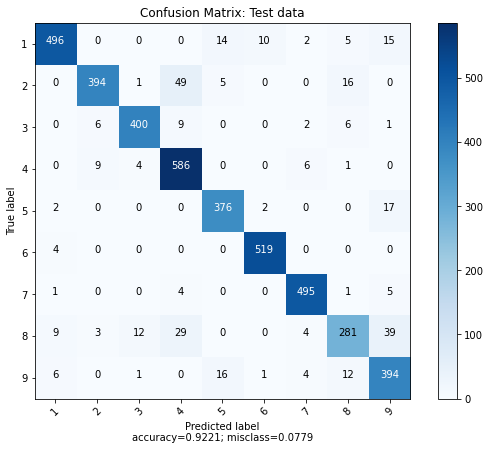

In [250]:
predictions = torch.argmax(torch.nn.functional.softmax(model(torch.from_numpy(x_train).float())),dim=1)
target = torch.argmax(torch.from_numpy(y_train), axis=1)

confuTst = torchmetrics.functional.confusion_matrix(predictions.detach().cpu(),target.int().detach().cpu(), cfg.AE_NUM_CLASSES)

plot.confusion_matrix(cm = confuTst.numpy(), 
                      normalize = False,
                      target_names = cfg.AE_CLASSES,
                      title = "Confusion Matrix: Test data")

## Task 2
For this last exercise the task is to train a binary classifier for the spiral problem. The aim is to get *zero* classification error for the training data (there is no test data) with as small as possible model, in terms of the number of trainable weights. Also plot the boundary to see if it resembles a spriral. To pass this question you should at least try!

**TODO:** Train a classifier for the spiral problem with the aim of zero classification error with as small as possible model. 

**TODO:** Motivate the choice of parameters and implementation.

In [88]:
# Load dataset
def numpy2Dataloader(x,y, batch_size=50, num_workers=0,**kwargs):
    return DataLoader(
        TensorDataset(
            torch.from_numpy(x).float(), 
            torch.from_numpy(y).float()
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        **kwargs
    )
x_train, y_train = MLPData.spiral(cfg.spiral_path)
y_train = y_train.reshape(-1, 1) # Was shape (194,), now it's (194, 1)
train_loader = numpy2Dataloader(x_train,y_train)

In [20]:
y_train.shape

(194, 1)

In [21]:
x_train.shape

(194, 2)

## Implement the TODO's

### Model

In [64]:
class MLP(torch.nn.Module):
    def __init__(self, 
                inp_dim=None,         
                hidden_nodes=1, # number of nodes in hidden layer
                num_layers=1,
                num_out=None,
                **kwargs
            ):
        super(MLP, self).__init__()
        layers = []
        # Input
        layers.append(torch.nn.Linear(inp_dim, hidden_nodes))
        layers.append(torch.nn.ReLU())
        # Hidden
        for i in range(num_layers):
            layers.append(torch.nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(torch.nn.ReLU())
        # Output
        layers.append(torch.nn.Linear(hidden_nodes, num_out))
        layers.append(torch.nn.Sigmoid())
        self.sequential = torch.nn.Sequential(*layers) # Unpacking all layers into a Sequential container
    def forward(self, x):
        return self.sequential(x)

### Config

In [267]:
config = {
    'max_epochs':1000,
    'model_params':{
        'inp_dim':x_train.shape[1],         
        'hidden_nodes':33,   # activation functions for the hidden layer,
        'hidden_layers':0,
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.011,
        }
    }
}

### Run Model

In [272]:
model = Model(MLP(**config["model_params"]),**config)

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=0,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[TQDMProgressBar(1)],
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
trainer.fit(
    model, 
    train_dataloaders=train_loader
);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 285.72it/s, loss=0.00364, v_num=172]


### Evaluation

In [273]:
plot.stats_class(x_train, y_train, 'Training', model)


 ########## STATISTICS for Training Data ########## 

Accuracy   1.0
Sensitivity   1.0
Specificity   1.0

 ##################################################


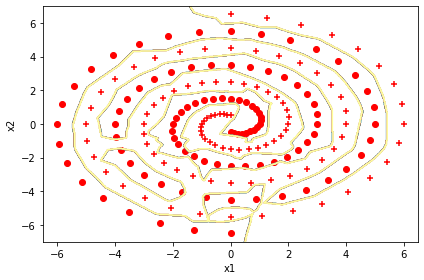

In [274]:
plot.decision_bondary(trainer.lightning_module, x_train, y_train.reshape(-1, ))

## Example of evaluation
Run the testset and evaluate the performance of the model.

In [141]:
# Move to correct device!
#trainer.test(model, test_dataloaders=test_loader)

In [142]:
#trainer.logged_metrics

### Confusion matrix 

In [143]:
# predictions = torch.argmax(torch.nn.functional.softmax(model(torch.from_numpy(x_train).float())),dim=1)
# target = torch.argmax(torch.from_numpy(y_train), axis=1)

# confuTst = torchmetrics.functional.confusion_matrix(predictions.detach().cpu(),target.int().detach().cpu(), cfg.AE_NUM_CLASSES)

# plot.confusion_matrix(cm = confuTst.numpy(), 
#                       normalize = False,
#                       target_names = cfg.AE_CLASSES,
#                       title = "Confusion Matrix: Test data")